In [22]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
data_path = Path('/Users/pengshuoliu/abstraction-and-reasoning-challenge')
train_path = data_path / 'training'
valid_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [18]:
train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() } 
valid_tasks = { task.stem: json.load(task.open()) for task in valid_path.iterdir() } 
test_tasks = { task.stem: json.load(task.open()) for task in test_path.iterdir() }

In [24]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

In [25]:
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()

In [26]:
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

In [27]:
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

In [28]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

In [29]:
def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

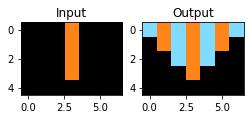

In [4]:
task = train_tasks["db3e9e38"]["train"]
for sample in task:
    plot_sample(sample)

In [5]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, num_states, kernel_size=1)
        )
        
    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x

In [34]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((max_steps - 1) * num_epochs)

    for num_steps in range(1, max_steps):
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.1 / (num_steps * 2)))
        
        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)
                
                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1) 
                loss += criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            losses[(num_steps - 1) * num_epochs + e] = loss.item()
    return model, num_steps, losses

In [35]:
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 100).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions

model:
 CAModel(
  (transition): Sequential(
    (0): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
num_steps 9
Last loss: 0.00000


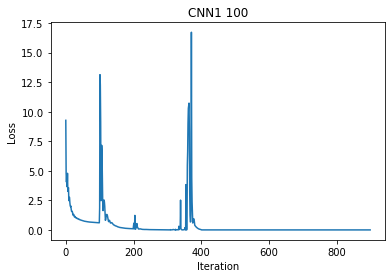

In [36]:
task = train_tasks["db3e9e38"]["train"]
model, num_steps, losses = solve_task(task)
print('model:\n', model)
print('num_steps', num_steps)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CNN1 100')
print(f"Last loss: {losses[-1]:.5f}")
plt.plot(losses)

In [20]:
def evaluate(tasks,is_test=False):
    result = []
    predictions = []
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
    return result, predictions

In [12]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [3:42:27<00:00, 33.37s/it]  

solved : 21 from 416 (0.05048076923076923)


0it [00:00, ?it/s]

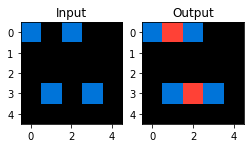

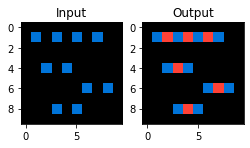

4it [00:01,  3.54it/s]

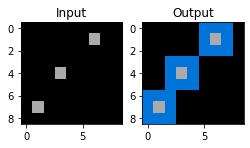

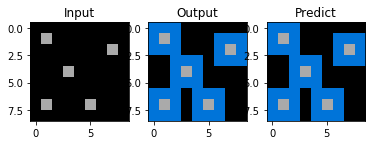

10it [00:01,  4.21it/s]

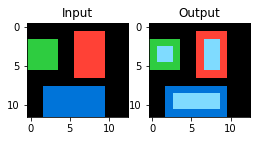

23it [00:03,  5.04it/s]

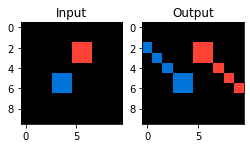

40it [00:04,  6.40it/s]

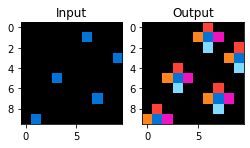

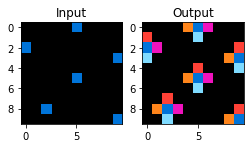

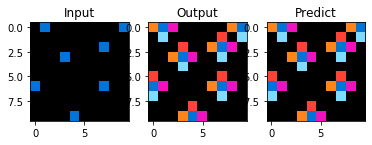

65it [00:05,  8.39it/s]

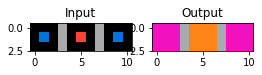

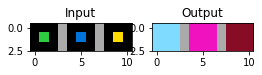

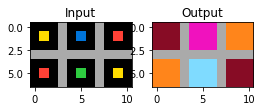

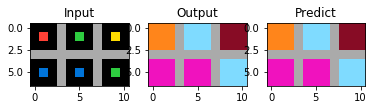

77it [00:06,  8.82it/s]

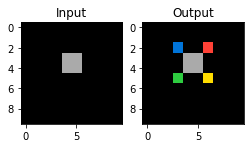

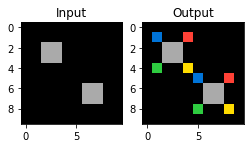

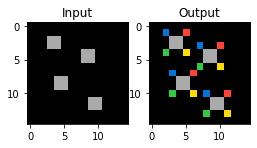

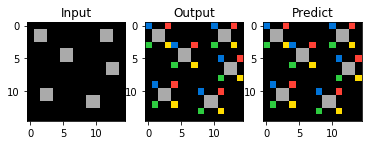

85it [00:07,  8.58it/s]

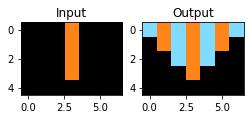

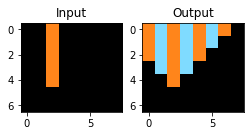

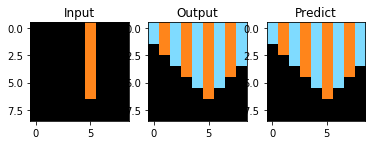

104it [00:08, 10.18it/s]

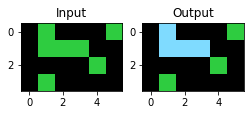

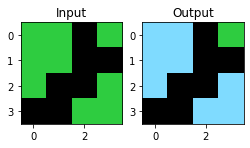

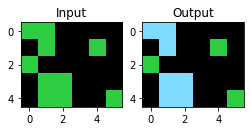

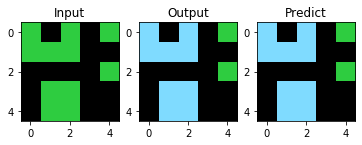

195it [00:09, 13.75it/s]

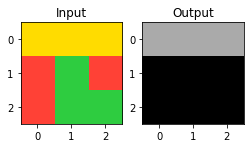

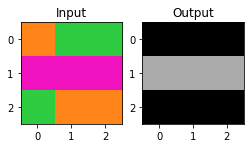

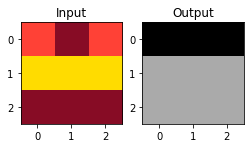

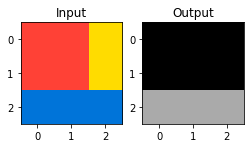

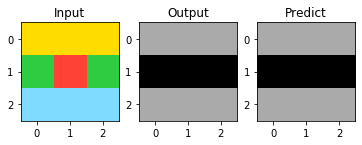

199it [00:10,  6.85it/s]

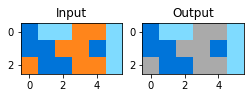

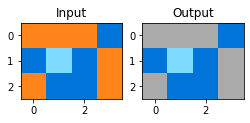

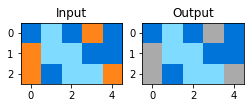

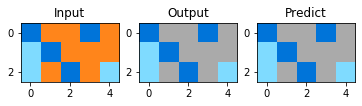

226it [00:11,  8.87it/s]

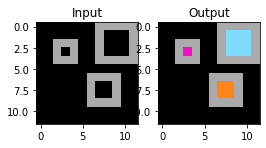

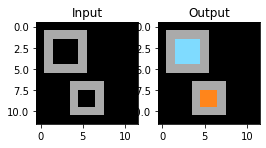

241it [00:12, 10.12it/s]

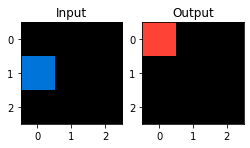

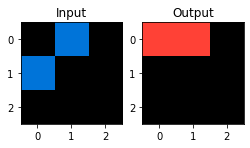

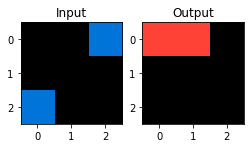

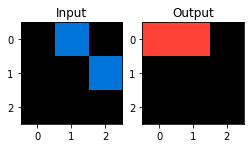

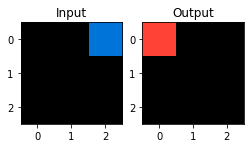

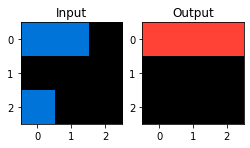

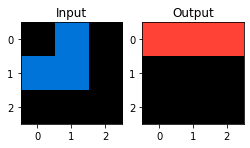

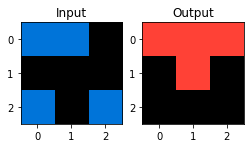

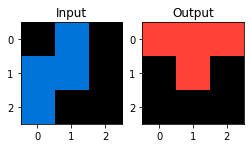

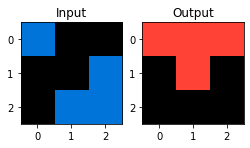

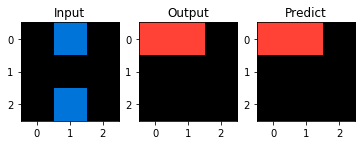

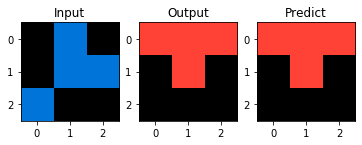

272it [00:15, 10.32it/s]

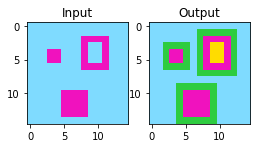

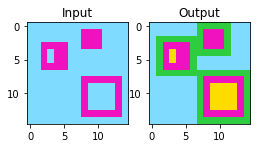

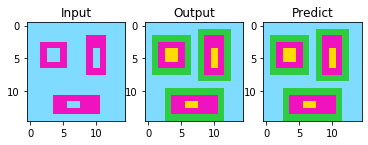

284it [00:16, 11.25it/s]

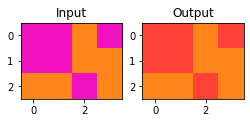

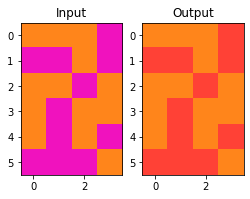

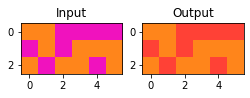

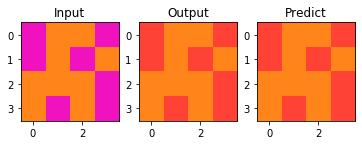

289it [00:17,  8.33it/s]

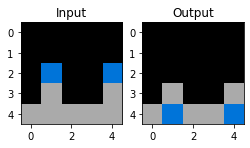

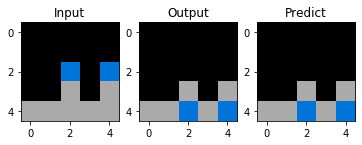

292it [00:18,  5.40it/s]

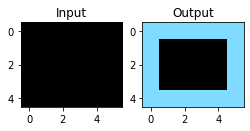

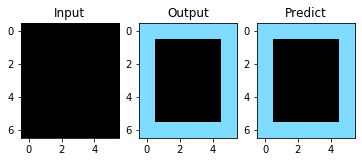

296it [00:19,  4.29it/s]

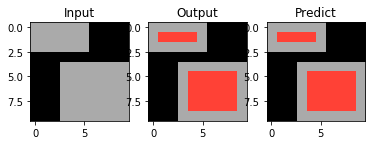

321it [00:20,  5.80it/s]

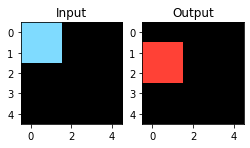

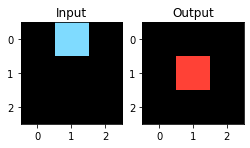

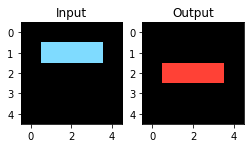

344it [00:21,  7.41it/s]

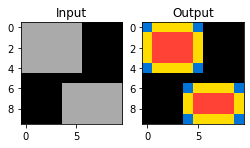

357it [00:22,  8.89it/s]

400it [00:23, 17.22it/s]


In [13]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

In [15]:
valid_result, valid_predictions = evaluate(valid_tasks)
valid_solved = [any(score) for score in valid_result]

total = sum([len(score) for score in valid_result])
print(f"solved : {sum(valid_solved)} from {total} ({sum(valid_solved)/total})")

100%|██████████| 400/400 [4:56:13<00:00, 44.43s/it]   

solved : 7 from 419 (0.016706443914081145)


0it [00:00, ?it/s]

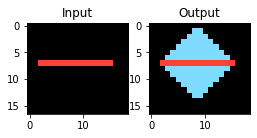

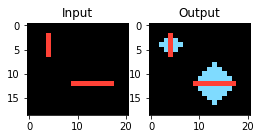

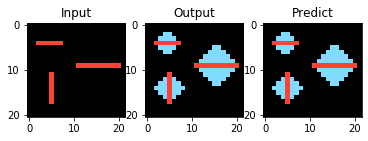

120it [00:01, 106.82it/s]

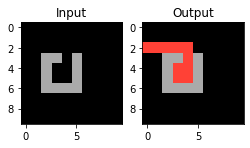

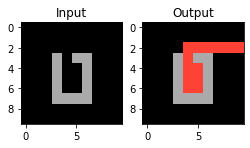

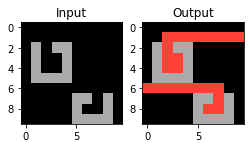

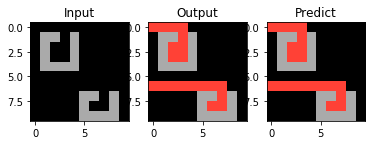

172it [00:02, 59.90it/s] 

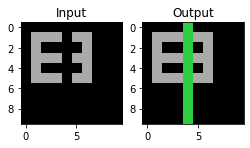

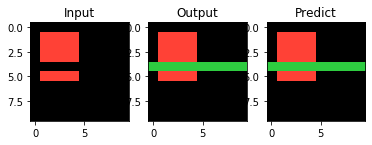

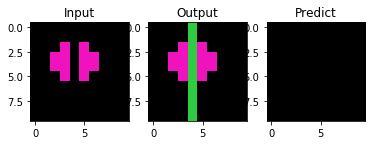

253it [00:04, 62.20it/s]

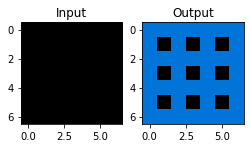

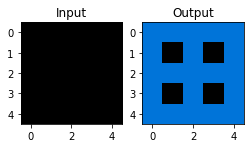

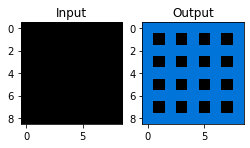

304it [00:05, 58.25it/s]

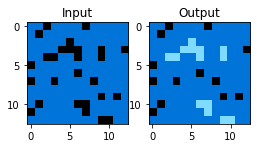

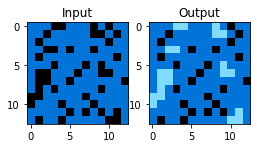

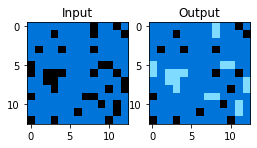

354it [00:05, 57.42it/s]

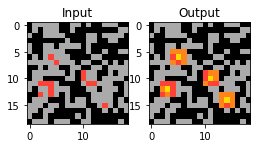

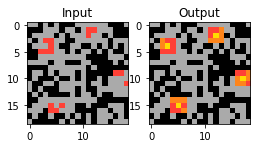

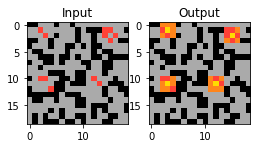

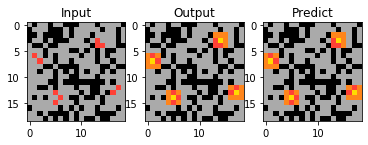

372it [00:06, 36.78it/s]

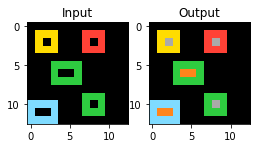

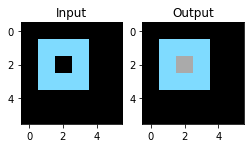

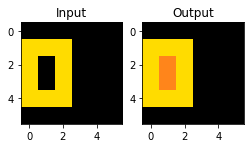

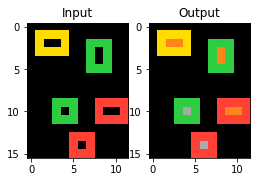

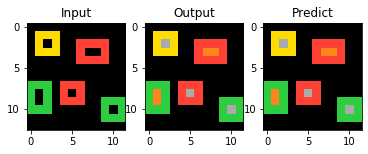

400it [00:08, 49.58it/s]


In [16]:
for task, prediction, solved in tqdm(zip(valid_tasks.values(), valid_predictions, valid_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

In [ ]:
test_result, test_predictions = evaluate(test_tasks, is_test=True)

In [ ]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

In [ ]:
def flattener(pred):
    str_pred = str([list(row) for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [ ]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    data = test_predictions[task_id][pair_id]
    pred_1 = flattener(data)
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

In [ ]:
submission.to_csv('submission_ca_cnn_act.csv')
submission.head()